In this week, you are required to implement a toy GATConv and SAGEConv based on document. Also, you need to implement both in PyG and DGL. In this work, you will get a further understanding of tensor-centric in PyG and graph-centric in DGL.

</style>


## DGL

In [1]:
import os

import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### GraphConv
Mathematically it is defined as follows:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $\mathcal{N}(i)$ is the set of neighbors of node $i$, 
$c_{ji}$ is the product of the square root of node degrees
$(i.e.,  c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|})$,
and $\sigma$ is an activation function.

If a weight tensor on each edge is provided, the weighted graph convolution is defined as:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{e_{ji}}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $e_{ji}$is the scalar weight on the edge from node $j$ to node $i$.
This is NOT equivalent to the weighted graph convolutional network formulation in the paper.

To customize the normalization term :$c_{ji}$, one can first set ``norm='none'`` for
the model, and send the pre-normalized :$e_{ji}$ to the forward computation. We provide
:class:`~dgl.nn.pytorch.EdgeWeightNorm` to normalize scalar edge weight following the GCN paper.

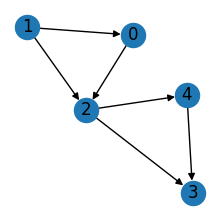

In [2]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g.ndata["h"] = h
edge_weight = torch.ones(g.num_edges())  # 给各个边赋格权重
g.edata["edge_weight"] = edge_weight
plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)




In [53]:
class DGL_GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(DGL_GraphConv, self).__init__()
        self.W = nn.Parameter(torch.rand(in_feats, out_feats))
        self.b = nn.Parameter(torch.rand(out_feats))

        nn.init.ones_(self.W.data)
        nn.init.ones_(self.b.data)
        
        self.activate = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            # 这里的normalization用了left+right，也就是考虑了出度+入度
            norm_src = g.out_degrees().clamp(min=1).view(-1, 1)
            norm_src = torch.pow(norm_src, -0.5)

            feat_src = norm_src * h
            feat_src = torch.matmul(feat_src, self.W)
            g.srcdata["h"] = feat_src
            g.update_all(fn.u_mul_e("h", "edge_weight", "he"), fn.sum("he", "rst"))
            rst = g.dstdata["rst"]

            norm_dst = g.in_degrees().clamp(min=1).view(-1, 1)
            norm_dst = torch.pow(norm_dst, -0.5)
            rst = rst * norm_dst

            rst += self.b
            return F.relu(rst)

In [56]:
in_feats = h.shape[1]
out_feats = in_feats  # *2

In [57]:
dgl_graphConv = DGL_GraphConv(in_feats, out_feats)
with torch.no_grad():
    out=dgl_graphConv(g, h)
    print(out)

tensor([[ 6.6569,  6.6569,  6.6569,  6.6569,  6.6569,  6.6569,  6.6569,  6.6569],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [10.6569, 10.6569, 10.6569, 10.6569, 10.6569, 10.6569, 10.6569, 10.6569],
        [10.6569, 10.6569, 10.6569, 10.6569, 10.6569, 10.6569, 10.6569, 10.6569],
        [ 6.6569,  6.6569,  6.6569,  6.6569,  6.6569,  6.6569,  6.6569,  6.6569]])


In [58]:
from dgl.nn import GraphConv

In [75]:
# torch.manual_seed(42)
gcn=GraphConv(in_feats,out_feats,norm='both',activation=F.relu)
nn.init.ones_(gcn.weight)
nn.init.ones_(gcn.bias)


Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [76]:
g_in=g.add_self_loop()
with torch.no_grad():
    out=gcn.forward(g_in,h)
    print(out)

tensor([[ 8.2660,  8.2660,  8.2660,  8.2660,  8.2660,  8.2660,  8.2660,  8.2660],
        [ 5.6188,  5.6188,  5.6188,  5.6188,  5.6188,  5.6188,  5.6188,  5.6188],
        [ 9.5993,  9.5993,  9.5993,  9.5993,  9.5993,  9.5993,  9.5993,  9.5993],
        [11.5515, 11.5515, 11.5515, 11.5515, 11.5515, 11.5515, 11.5515, 11.5515],
        [ 8.2660,  8.2660,  8.2660,  8.2660,  8.2660,  8.2660,  8.2660,  8.2660]])


### GATConv
Graph attention layer from Graph Attention Network
$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and
node $j$:

$$
\begin{align}\begin{aligned}\alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})\\e_{ij}^{l} &= 
\mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)\end{aligned}\end{align}
$$

这里的 $softmax_i$ 是对节点$i$的多个边进行归一化，不考虑其他边

In [40]:
from dgl.nn.functional import edge_softmax


class DGL_GATConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(DGL_GATConv, self).__init__()
        # self.W=nn.Parameter(torch.rand(in_feats,out_feats))
        # self.a=nn.Parameter(torch.rand(2*in_feats,1))
        self.W = nn.Linear(in_feats, out_feats, bias=False)
        self.a_fc = nn.Linear(out_feats * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU()

    def edge_attention(self, edges):
        hiW = self.W(edges.dst["h"])
        hjW = self.W(edges.src["h"])
        h_cat = torch.cat([hiW, hjW], dim=1)
        e = self.leakyrelu(self.a_fc(h_cat))
        return {"e": e}

    def forward(self, g: dgl.graph, h, get_attention=False):
        with g.local_scope():
            g=g.remove_self_loop().add_self_loop()
            g.apply_edges(self.edge_attention)
            e = g.edata["e"]
            alpha = edge_softmax(g, e)
            g.edata["alpha"] = alpha
            hW = self.W(h)

            g.ndata["hW"] = hW
            g.update_all(fn.u_mul_e("hW", "alpha", "m"), fn.sum("m", "hN"))
            hN = g.ndata["hN"]

            if get_attention:
                return hN, alpha
            else:
                return hN

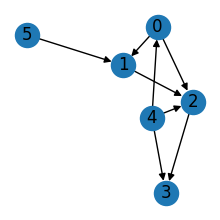

In [42]:
# src = torch.tensor([0, 1, 1, 2, 2, 4])
# dst = torch.tensor([2, 0, 2, 3, 4, 3])
# h = torch.ones((5, 8))

# g = dgl.graph((src, dst))
# g = dgl.add_self_loop(g)
# g.ndata["h"] = h
# g

g = dgl.graph(([0, 0, 1, 2, 4, 4, 4, 5], [1, 2, 2, 3, 0, 2, 3, 1]))
g.ndata["h"] = torch.FloatTensor(
    [
        [0, 0, 0, 0],  # 0
        [1, 1, 1, 1],  # 1
        [2, 2, 2, 2],  # 2
        [3, 3, 3, 3],  # 3
        [4, 4, 4, 4],  # 4
        [5, 5, 5, 5],  # 5
    ]
)
g.edata["edge_attr"] = torch.ones(g.num_edges())

# g=g.remove_self_loop().add_self_loop()

plt.figure(figsize=(2,2))
nx.draw(dgl.to_networkx(g), with_labels=True)

In [43]:
in_feats=g.ndata['h'].shape[1]
out_feats=3

myGATConv = DGL_GATConv(in_feats,out_feats)
torch.nn.init.ones_(myGATConv.W.weight)
torch.nn.init.ones_(myGATConv.a_fc.weight)

print(myGATConv.W.weight)
print(myGATConv.a_fc.weight)

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1.]], requires_grad=True)


In [46]:
with torch.no_grad():
    out,attention=myGATConv(g, g.ndata['h'], get_attention=True)
    print(out)
    print(attention)

tensor([[16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])
tensor([[8.7565e-27],
        [1.4252e-21],
        [2.3195e-16],
        [3.7751e-11],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [1.0000e+00],
        [1.4252e-21],
        [1.4252e-21],
        [3.7751e-11],
        [6.1442e-06],
        [1.0000e+00],
        [1.0000e+00]])


#### 与dgl实现对比验证

In [33]:
# Case 1: Homogeneous graph
from dgl.nn import GATConv


In [34]:
gatconv = GATConv(in_feats,out_feats, num_heads=1)

torch.nn.init.ones_(gatconv.fc.weight)
torch.nn.init.ones_(gatconv.attn_l)
torch.nn.init.ones_(gatconv.attn_r)

print(gatconv.fc.weight)
print(gatconv.attn_l)
print(gatconv.attn_r)

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)


In [39]:
g_in=g.remove_self_loop().add_self_loop()
with torch.no_grad():
    out,attention=(gatconv(g_in, g_in.ndata['h'], get_attention=True))
    print(out)
    print(attention)

tensor([[[16.0000, 16.0000, 16.0000]],

        [[20.0000, 20.0000, 20.0000]],

        [[16.0000, 16.0000, 16.0000]],

        [[16.0000, 16.0000, 16.0000]],

        [[16.0000, 16.0000, 16.0000]],

        [[20.0000, 20.0000, 20.0000]]])
tensor([[[8.7565e-27]],

        [[1.4252e-21]],

        [[2.3195e-16]],

        [[3.7751e-11]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[9.9999e-01]],

        [[1.0000e+00]],

        [[1.4252e-21]],

        [[1.4252e-21]],

        [[3.7751e-11]],

        [[6.1442e-06]],

        [[1.0000e+00]],

        [[1.0000e+00]]])


In [51]:
# 完全相同捏
# tensor([[16.0000, 16.0000, 16.0000],
#         [20.0000, 20.0000, 20.0000],
#         [16.0000, 16.0000, 16.0000],
#         [16.0000, 16.0000, 16.0000],
#         [16.0000, 16.0000, 16.0000],
#         [20.0000, 20.0000, 20.0000]])
# tensor([[8.7565e-27],
#         [1.4252e-21],
#         [2.3195e-16],
#         [3.7751e-11],
#         [1.0000e+00],
#         [1.0000e+00],
#         [9.9999e-01],
#         [1.0000e+00],
#         [1.4252e-21],
#         [1.4252e-21],
#         [3.7751e-11],
#         [6.1442e-06],
#         [1.0000e+00],
#         [1.0000e+00]])

### SAGEConv
$$
\begin{align}\begin{aligned}
h_{\mathcal{N}(i)}^{(l+1)} &= \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)\\\\
h_{i}^{(l+1)} &= \sigma \left(W \cdot \mathrm{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)\\\\
h_{i}^{(l+1)} &= \mathrm{norm}(h_{i}^{(l+1)})\\\\
\mathrm{norm}(v) &= \frac{v}{\max(\lVert v \rVert_p,\epsilon)}
\end{aligned}\end{align}
$$

If a weight tensor on each edge is provided, the aggregation becomes:
$$
h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}
\left(\{e_{ji} h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)
$$
where $e_{ji}$ is the scalar weight on the edge from node $j$ to node $i$.
    Please make sure that $e_{ji}$ is broadcastable with $h_j^{l}$.



In [300]:
src = torch.tensor([0, 1, 1, 2, 2, 4, 1])
dst = torch.tensor([2, 0, 2, 3, 4, 3, 3])
h = torch.ones((5, 8))
h = torch.FloatTensor(
    [
        [0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
    ]
)

g = dgl.graph((src, dst))
g.edata["e"] = torch.ones(g.num_edges(), dtype=torch.float)
g.ndata["h"] = h
# g = g.add_self_loop()

in_feats = 5
out_feats = 7
g

Graph(num_nodes=5, num_edges=7,
      ndata_schemes={'h': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(), dtype=torch.float32)})

tensor([1, 0, 2, 3, 1])


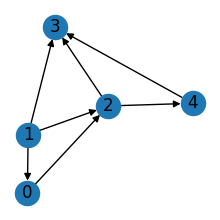

In [301]:
plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)
print(g.in_degrees())

由于DGL的消息传递机制，在msg_func中传入参数为edges，通过edges.src和.dst来获取边两端的节点。
```python
def get_neighbour(edges: dgl.udf.EdgeBatch):
    hN = edges.src["h"] # 邻居
    hi = edges.dst["h"] # 自身
    h_cat = torch.cat([hi, hN], dim=1) #拼接
    # 然而这么做，当某个节点没有输入边时，自己的特征也会被设置成0
    return {"h_cat": h_cat}
```
当某个节点没有输入边时，比如上图的节点1，则在update时，msg_func中无法获取1节点自身的信息，便在reduce_func中自动将传入数据设为0。结果变为
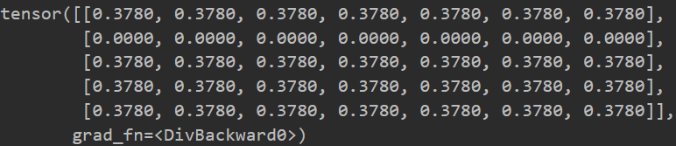

解决方式：

- 1. 增加self_loop

  2. [先汇聚再拼接](#先汇聚再拼接)

     ```python
       g.update_all(fn.copy_u('h','tmp'),fn.sum('tmp','hN')) # 先聚合邻居
       hN=g.dstdata['hN']
       h_cat=torch.cat([hi,hN],dim=1) # 再进行拼接
       h_cat=relu(W(h_cat))
       n=F.normalize(h_cat,dim=1)
     ```
     <br>
     
     
      

  3. [将W拆开](#将W拆开)     拆开成W_self与W_neighbour，shape都是（d,s），分别与hi，hN相乘，得到（n,s）, 之后相加。本质上是分块矩阵计算

#### 先汇聚再拼接

In [302]:
W = nn.Linear(in_feats * 2, out_feats, bias=False)
relu = nn.ReLU()
nn.init.ones_(W.weight)

with g.local_scope():
    hi = g.ndata["h"]
    # zeros=torch.zeros_like(hi)
    # hi=torch.cat([hi,zeros],dim=1)
    g.update_all(fn.copy_u("h", "tmp"), fn.sum("tmp", "hN"))
    hN = g.dstdata["hN"]
    h_cat = torch.cat([hi, hN], dim=1)
    h_cat = relu(W(h_cat))
    n = F.normalize(h_cat, dim=1)

    print(n)

tensor([[0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780]],
       grad_fn=<DivBackward0>)


#### 将W拆开

In [312]:
class DGL_SAGEConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(DGL_SAGEConv, self).__init__()
        self.w_neighbour = nn.Linear(in_feats, out_feats, bias=False)
        self.w_self = nn.Linear(in_feats, out_feats, bias=False)
        torch.nn.init.ones_(self.w_neighbour.weight)
        torch.nn.init.ones_(self.w_self.weight)

    def forward(self, g: dgl.graph, h):
        with g.local_scope():
            g.srcdata["h"] = h
            g.update_all(fn.copy_u("h", "tmp"), fn.sum("tmp", "hN"))
            h_N = g.dstdata["hN"]
            h_self = self.w_self(h)
            h_neighbour = self.w_neighbour(h_N)
            rst = F.relu(h_self + h_neighbour)

            return F.normalize(rst, dim=1)

In [313]:
mySAGEConv = DGL_SAGEConv(in_feats, out_feats)

In [314]:
mySAGEConv(g, h)

tensor([[0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780]],
       grad_fn=<DivBackward0>)

#### 与dgl实现对比验证

In [294]:
from dgl.nn import SAGEConv

sageconv = SAGEConv(
    in_feats,
    out_feats,
    aggregator_type="mean",
    bias=False,
    activation=relu,
    norm=F.normalize,
)

nn.init.ones_(sageconv.fc_neigh.weight)
nn.init.ones_(sageconv.fc_self.weight)
print(sageconv.fc_neigh.weight)
print(sageconv.fc_self.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)


In [295]:
sageconv(g, h)

tensor([[0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780]],
       grad_fn=<DivBackward0>)

In [ ]:
# 一样一样
# tensor([[0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
#         [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
#         [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
#         [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
#         [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780]],
#        grad_fn=<DivBackward0>)